## Метод, основанные на статистических признаках, признаках их ЭЭГ и признаках Воронцова-Успенского

In [1]:
import numpy as np
from scikits.audiolab import Sndfile
from scipy import signal
import seaborn as sns
import os
from scikits.audiolab import wavread
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.signal import wiener
import xgboost as xgb
from sklearn.cross_validation import LabelKFold
from biosppy.signals import ecg
from tqdm import tqdm
import math

/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from matplotlib import pyplot as plt

## Считывание данных

In [3]:
def read_frame(directory, filename):
    data, sample_frequency, encoding = wavread(directory + "/" + filename)
    return np.array(data)

def get_frames(directory, files):
    frames = []
    for i in files:
        patient = i.split("_")[0]
        ecg_id = i[:-4]
        a = read_frame(directory, i)
        frames.append([a, patient, ecg_id])
    frames = np.array(frames)
    return np.swapaxes(frames, 0, 1)

def create_data_frame_from_wav(true_files_dir, false_files_dir):
    true_files = filter(lambda x: x.endswith(".wav"), os.listdir(true_files_dir))
    false_files = filter(lambda x: x.endswith(".wav"), os.listdir(false_files_dir))
    true_frames = get_frames(true_files_dir, true_files)
    false_frames = get_frames(false_files_dir, false_files)
    a = create_data_frame(true_frames, True)
    b = create_data_frame(false_frames, False)
    df = a.append(b).copy()
    del a
    del b
    df = shuffle(df, random_state=27)
    df = df.reset_index()
    df.drop("index", axis=1, inplace=True)
    df["SignalLen"] = df["S"].apply(lambda x: len(x))
    df = df[df["SignalLen"] != 0].copy()
    return df

def create_data_frame(data, ibs):
    df = pd.DataFrame({"S":data[0], "Patient": data[1], "ibs":ibs, "ECG_ID":data[2]})
    return df

#df_p = create_data_frame_from_wav("preprocessed/wav/true", "preprocessed/wav/false")

In [4]:
df_train = create_data_frame_from_wav("wav/true", "wav/false")
df_test = create_data_frame_from_wav("wav_test/true", "wav_test/false")

ecg_ids = pd.read_csv("test_ids.csv", header=None)
df_test = df_test[df_test["ECG_ID"].isin(ecg_ids[0])]

Предобработка данных

In [5]:
N  = 2   # Filter order
Wn = 0.05 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')

In [20]:
df_p["FS"] = df_p["S"].apply(lambda x : signal.filtfilt(B, A, x))
df_p["S_Squared"] = df_p["S"].apply(lambda x : x * x)
df_p["FS_Squared"] = df_p["FS"].apply(lambda x : x * x)

In [6]:
df_test["FS"] = df_test["S"].apply(lambda x : signal.filtfilt(B, A, x))
df_test["S_Squared"] = df_test["S"].apply(lambda x : x * x)
df_test["FS_Squared"] = df_test["FS"].apply(lambda x : x * x)

## Признаки, основанные на статистических характеристиках

In [7]:
percentile_list = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]) * 100

In [8]:
def get_sum_g(x, i):
    x = x.copy()
    x[x < i] = 0
    return np.sum(x)

def get_sum_l(x, i):
    x = x.copy()
    x[x >= i] = 0
    return np.sum(x)

def get_sum_g2(xf, x, i):
    x = x.copy()
    x[xf < i] = 0
    return np.sum(x)

def get_sum_l2(xf, x, i):
    x = x.copy()
    x[xf >= i] = 0
    return np.sum(x)

def get_percentile_features(df, col, p):
    df = df.copy()
    
    df[col + "_" + str(int(p))] = df[col].apply(lambda x: np.percentile(x, p))
    
    df[col + "_" + str(int(p)) + "sg"] = df[[col, col + "_" + str(int(p))]].apply(lambda x: get_sum_g(x[0], x[1]), axis=1)
    df[col + "_" + str(int(p)) + "sl"] = df[[col, col + "_" + str(int(p))]].apply(lambda x: get_sum_l(x[0], x[1]), axis=1)
    df[col + "_" + str(int(p)) + "sg2"] = df[[col, col + "_Squared", col + "_" + str(int(p))]].apply(lambda x: get_sum_g2(x[0], x[1], x[2]), axis=1)
    df[col + "_" + str(int(p)) + "sl2"] = df[[col, col + "_Squared", col + "_" + str(int(p))]].apply(lambda x: get_sum_l2(x[0], x[1], x[2]), axis=1)
    
    return df

In [9]:
def create_stat_features(df, col, percentile_list, verbose):
    df = df.copy()
    df[col+"_mean"] = df[col].apply(lambda x: np.mean(x))
    df[col+"_std"] = df[col].apply(lambda x: np.std(x))
    df[col+"_min"] = df[col].apply(lambda x: np.min(x))
    df[col+"_max"] = df[col].apply(lambda x: np.max(x))
    
    for p in tqdm(percentile_list, "Percentile Features, " + col):
        df = get_percentile_features(df, col, p)
        
    for i in range(0, len(percentile_list)):
        for k in range(i+1, len(percentile_list)):
            first = str(int(percentile_list[i]))
            second = str(int(percentile_list[k]))
            df[col+"_" + first + "-" + second] = df[col + "_" + first] - df[col + "_" + second]
            
    x = df[col] - df[col+"_mean"]
    df[col + "_Skew"] = x.apply(lambda z : (z * z * z).mean() / (np.power((z * z).mean(), 1.5)))
    df[col + "_Kurt"] = x.apply(lambda z : (z * z * z * z).mean() / (np.power((z * z).mean(), 2.0)) - 3)

    return df

## Признаки ЭЭГ

In [10]:
def get_activity(array):
    return np.power(np.std(array), 2)

def create_Hjorth_features(array):
    activity = get_activity(array)
    derivative = np.diff(array)
    dactivity = get_activity(derivative)
    d2 = np.diff(derivative)
    d2activity = get_activity(d2)
    
    mobility = np.sqrt(dactivity / activity)
    dmobility = np.sqrt(d2activity / dactivity)
    
    complexity = dmobility / mobility
    
    return activity, mobility, complexity

def create_EEG_features(df, col):
    tqdm.pandas(desc="EEG Features, " + col)
    
    z = df[col].progress_apply(create_Hjorth_features)
    
    HjorthDF = pd.DataFrame(data = np.asarray(z.values.tolist()), 
                            index = df.index, 
                            columns = [col + "_Activity", col + "_Mobility", col + "_Complexity"])
    
    df = pd.concat([df, HjorthDF], axis = 1)
    
    return df

## Вычисление R-пиков и признаков Ворнцова Успенского

In [11]:
def create_peaks_features(df, col):
    df = df.copy()
    
    tqdm.pandas(desc="Peaks Features, " + col)
    
    df[col + "_RPeaks"] = df[col].progress_apply(lambda x: ecg.hamilton_segmenter(x)["rpeaks"])
    df[col + "_FirstRPeaks"] = df[col + "_RPeaks"].progress_apply(lambda x: x[0])
    df[col + "_LastRPeaks"] = df[col + "_RPeaks"].progress_apply(lambda x: x[len(x)-1])
    df[col + "_MedianRPeaks"] = df[col + "_RPeaks"].progress_apply(lambda x: np.median(x))
    return df

In [12]:
def get_vu_dict():
    letters = ["a", "b", "c", "d", "e",  "f"]
    d = {}
    for i in letters:
        for j in letters:
            for k in letters:
                d[i + j + k] = 0
    return d  

In [13]:
def get_r_t_alpha(r_peaks, signal):
    drn_s = []
    tn_s = []
    alphan_s = []
    for i in range(len(r_peaks)-1):
        dr = signal[r_peaks[i+1]] - signal[r_peaks[i]]
        t = r_peaks[i+1] - r_peaks[i]
        alpha = math.atan(signal[r_peaks[i]]* 1.0 / t)
        drn_s.append(dr)
        tn_s.append(t)
        alphan_s.append(alpha)
        
    dtn_s = []
    dalpha_s = []
    
    for i in range(len(tn_s)-1):
        dtn_s.append(tn_s[i+1] - tn_s[i])
        dalpha_s.append(alphan_s[i+1] - alphan_s[i])
    return (drn_s, dtn_s, dalpha_s)  

In [14]:
def get_seq(rn, tn, an):
    s = []
    for i in range(len(tn)):
        if (rn[i] >= 0) and (tn[i] >= 0) and (an[i] >= 0):
            s.append("a")
        elif (rn[i] < 0) and (tn[i] < 0) and (an[i] >= 0):
            s.append("b")
        elif (rn[i] >= 0) and (tn[i] < 0) and (an[i] >= 0):
            s.append("c")
        elif (rn[i] < 0) and (tn[i] >= 0) and (an[i] < 0):
            s.append("d")
        elif (rn[i] >= 0) and (tn[i] >= 0) and (an[i] < 0):
            s.append("e")
        elif (rn[i] < 0) and (tn[i] < 0) and (an[i] < 0):
            s.append("f")
    return s

In [15]:
def get_trigram_counts(s):
    d = get_vu_dict()
    for i in range(len(s) - 2):
        d[s[i] + s[i+1] + s[i+2]] += 1
    return d

In [16]:
def get_VU(r, s):
    k = get_r_t_alpha(r, s)
    s = get_seq(k[0], k[1], k[2])
    d = get_trigram_counts(s)
    return d

In [17]:
def get_VU_df(df, rpeaks, signal, pr):
    df = df.copy()
    df["VU_dict"] = df[[rpeaks, signal]].apply(lambda x : get_VU(x[0], x[1]), axis=1)
    keys = get_vu_dict().keys()
    for k in sorted(keys):
        df[pr + "_VU_" + k] = df["VU_dict"].apply(lambda x: x[k])
    df.drop("VU_dict", axis=1, inplace=True)
    return df

In [18]:
def create_features(df, percentile_list):
    df = create_peaks_features(df, "S")
    df = create_peaks_features(df, "FS")
    
    df = create_stat_features(df, "FS", percentile_list, verbose = False)
    df = create_stat_features(df, "S", percentile_list, verbose = False)
    
    df = create_EEG_features(df, "S")
    df = create_EEG_features(df, "FS")
    
    df = get_VU_df(df, "S_RPeaks", "S", "S")
    df = get_VU_df(df, "FS_RPeaks", "FS", "FS")
    
    return df

In [33]:
df_p = create_features(df_p, percentile_list)

EEG Features, FS: 100%|██████████| 1798/1798 [01:20<00:00, 22.33it/s]


In [19]:
f_df_test = create_features(df_test, percentile_list)

EEG Features, FS: 100%|██████████| 1567/1567 [00:20<00:00, 77.45it/s] 


In [21]:
f_df_train = pd.read_csv("df_p_f_stat.csv")

In [34]:
#new_f_filt = create_features(new_df_filtered, percentile_list)

In [35]:
df_p.drop(["S", "FS", "S_Squared", "FS_Squared"], axis = 1).to_csv("df_p_f_stat.csv")

In [24]:
from sklearn.cross_validation import train_test_split

## Функции для обучения классификаторов

In [25]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [28]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [43]:
%matplotlib inline

In [44]:
cv = LabelKFold(df_p["Patient"], n_folds=12)

In [45]:
def cv_tt(df, target, cv):
    tt = []
    train_data = df.drop(target, axis = 1)
    y = df[target]
    for itrain, itest in cv:
        fold = {"xtrain" : train_data.loc[itrain,:], "ytrain" : y[itrain], 
                "xtest" : train_data.loc[itest,:], "ytest" : y[itest]}
        tt.append(fold)
    return tt

In [46]:
cv_train_test = cv_tt(df_p, "ibs", cv)

In [40]:
def fit_predict(clf, xtrain, ytrain, xtest, ytest, clf_params, 
               fit_params, do_scaling, xgbfit, nnfit):
    if do_scaling:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
            
    if xgbfit:
        fit_params["eval_set"] = \
            [(xtrain, ytrain), (xtest, ytest)]
        fit_params["sample_weight"] = \
            np.array(get_weight(ytrain))
    if nnfit:
        fit_params["w"] = \
            np.array(get_weight(ytrain))
            
    c = clf(**clf_params)
    c.fit(xtrain, ytrain, **fit_params)
    
    p_tr = c.predict(xtrain)
    pr_tr = c.predict_proba(xtrain)[:,1] 
    p_tst = c.predict(xtest)
    pr_tst = c.predict_proba(xtest)[:,1]
    
    return  p_tst, pr_tst

In [41]:
def cv_fit_predict(clf, cv_tt, f_l, clf_params = {}, fit_params = {},
                   do_scaling = False, xgbfit = False, nnfit = False):
    cv_answer = []
    
    for fold in tqdm(cv_tt):
        p_tr, pr_tr, p_tst, pr_tst = fit_predict(clf, fold["xtrain"][f_l], fold["ytrain"], 
                                      fold["xtest"][f_l], fold["ytest"], 
                                      clf_params, fit_params, do_scaling, xgbfit, nnfit)
        tt_answer = {"p_train" : p_tr, "pr_train" : pr_tr, 
                     "p_test" : p_tst, "pr_test" : pr_tst}
        cv_answer.append(tt_answer)
    
    return cv_answer

In [42]:
def get_prediction(clf, train, y_train, test, y_test, clf_params, fit_params, do_scaling = True,
                   xgbfit = False, nnfit = False):
    p_tst, pr_tst = fit_predict(clf, train, y_train, 
                                             test, y_test, 
                                             clf_params, fit_params, do_scaling, xgbfit, nnfit)
    return p_tst, pr_tst

In [43]:
def patient_score(label, target_val, p=None):
    tmp = pd.DataFrame({'label':label, 'q':target_val == p})
    return tmp.groupby('label')['q'].mean().mean()

## Результаты на тестовой выборке

In [44]:
lrclf_params = {"C": 0.62, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
vu_columns = [i for i in f_df_test.columns if i.startswith("S_VU")]
lr_f = ['FS_Activity', u'FS_Mobility', u'FS_Complexity',  u'S_FirstRPeaks', u'S_LastRPeaks', 
               u'S_MedianRPeaks', u'FS_mean',
       u'FS_std', u'FS_min', u'FS_max', u'FS_5', u'FS_5sg', u'FS_5sl',
       u'FS_5sg2', u'FS_5sl2', u'FS_10', u'FS_10sg', u'FS_10sl', u'FS_10sg2',
       u'FS_10sl2', u'FS_25', u'FS_25sg', u'FS_25sl', u'FS_25sg2', u'FS_25sl2',
       u'FS_50', u'FS_50sg', u'FS_50sl', u'FS_50sg2', u'FS_50sl2', u'FS_75',
       u'FS_75sg', u'FS_75sl', u'FS_75sg2', u'FS_75sl2', u'FS_90', u'FS_90sg',
       u'FS_90sl', u'FS_90sg2', u'FS_90sl2', u'FS_95', u'FS_95sg', u'FS_95sl',
       u'FS_95sg2', u'FS_95sl2', u'FS_5-10', u'FS_5-25', u'FS_5-50',
       u'FS_5-75', u'FS_5-90', u'FS_5-95', u'FS_10-25', u'FS_10-50',
       u'FS_10-75', u'FS_10-90', u'FS_10-95', u'FS_25-50', u'FS_25-75',
       u'FS_25-90', u'FS_25-95', u'FS_50-75', u'FS_50-90', u'FS_50-95',
       u'FS_75-90', u'FS_75-95', u'FS_90-95', u'S_Skew', u'S_Kurt'] 
lr_f += vu_columns
p_tst_lr, pr_tst_lr = get_prediction(LogisticRegression, f_df_train[lr_f], f_df_train["ibs"], 
                        f_df_test[lr_f], f_df_test["ibs"], lrclf_params, lrfit_params, do_scaling = True)

In [50]:
lr_p_t = np.zeros(pr_tst_lr.shape)
lr_p_t[pr_tst_lr>0.61] = 1

In [51]:
roc_auc_score(f_df_test["ibs"], pr_tst_lr)

0.92370605679958195

In [52]:
print patient_score(f_df_test["Patient"], f_df_test["ibs"], lr_p_t)
print accuracy_score(f_df_test["ibs"], lr_p_t)
print f1_score(f_df_test["ibs"], lr_p_t)

0.630849519316
0.848755583918
0.781163434903


In [53]:
xgb_f = [u'S_FirstRPeaks', u'S_LastRPeaks',
             u'S_MedianRPeaks', u'S_Activity', u'S_Mobility', u'S_Complexity',
             u'FS_mean', u'FS_std', u'FS_min', u'FS_max',
       u'FS_5', u'FS_5sg', u'FS_5sl', u'FS_5sg2', u'FS_5sl2', u'FS_10',
       u'FS_10sg', u'FS_10sl', u'FS_10sg2', u'FS_10sl2', u'FS_25', u'FS_25sg',
       u'FS_25sl', u'FS_25sg2', u'FS_25sl2', u'FS_50', u'FS_50sg', u'FS_50sl',
       u'FS_50sg2', u'FS_50sl2', u'FS_75', u'FS_75sg', u'FS_75sl', u'FS_75sg2',
       u'FS_75sl2', u'FS_90', u'FS_90sg', u'FS_90sl', u'FS_90sg2', u'FS_90sl2',
       u'FS_95', u'FS_95sg', u'FS_95sl', u'FS_95sg2', u'FS_95sl2', u'FS_5-10',
       u'FS_5-25', u'FS_5-50', u'FS_5-75', u'FS_5-90', u'FS_5-95', u'FS_10-25',
       u'FS_10-50', u'FS_10-75', u'FS_10-90', u'FS_10-95', u'FS_25-50',
       u'FS_25-75', u'FS_25-90', u'FS_25-95', u'FS_50-75', u'FS_50-90',
       u'FS_50-95', u'FS_75-90', u'FS_75-95', u'FS_90-95', u'S_Skew',
       u'S_Kurt'] 
xgb_f += vu_columns
xgbclf_params = {"objective":"binary:logistic", "max_depth":7, "learning_rate":0.05,
                 "n_estimators": 300, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"auc", "early_stopping_rounds":900, "verbose": False}

In [54]:
p_tst_xgb, pr_tst_xgb = get_prediction(xgb.XGBClassifier, f_df_train[xgb_f], f_df_train["ibs"], 
                                      f_df_test[xgb_f], f_df_test["ibs"], xgbclf_params, xgbfit_params,
                                      do_scaling = False, xgbfit = True)

In [55]:
roc_auc_score(f_df_test["ibs"], pr_tst_xgb)

0.94810385457867474

In [56]:
xgb_p_t = np.zeros(pr_tst_xgb.shape)
xgb_p_t[pr_tst_xgb>0.445] = 1

In [57]:
print patient_score(f_df_test["Patient"], f_df_test["ibs"], xgb_p_t)
print accuracy_score(f_df_test["ibs"], xgb_p_t)
print f1_score(f_df_test["ibs"], xgb_p_t)

0.787862190163
0.876196553925
0.839669421488


In [59]:
r_df = pd.DataFrame(data={"ibs":f_df_test["ibs"], "ECG_ID":f_df_test["ECG_ID"], 
                            "STAT_PR_LR": pr_tst_lr,
                            "STAT_P_LR":p_tst_lr,
                            "STAT_P_NEW_LR":lr_p_t,
                            "STAT_PR_XGB":pr_tst_xgb,
                            "STAT_P_XGB":p_tst_xgb,
                            "STAT_P_NEW_XGB":xgb_p_t})

In [61]:
r_df.to_csv("test_stat_results.csv")

## Результаты на кросс-валидации

In [49]:
def review(df, p=None, pr=None, target="ibs", plot = True, text = True):
    lsp = np.linspace(0, 1, 201)
    if pr is not None:
        s = [pd.DataFrame({'label':df["Patient"], 'q':(df[target] == (pr >= l).astype(float))}).q.mean() for l in lsp]
        patients = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df[target] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() for l in lsp]
    
    if plot: 
        plt.figure(figsize = (8, 4))    
        plt.plot(lsp, patients, lw=2)
        plt.plot(lsp, s, lw=2)
        plt.xlabel('threshold')
        plt.ylabel('quality')
    if p is not None: 
        tmp = pd.DataFrame({'label':df["Patient"], 'q':df[target] == p})
    tmax = np.argmax(patients)
    
    if text:
        print ('roc-auc = ' + str(roc_auc_score(df[target], pr)))
        if p is not None:
            print ("Оценка границы разбиения по умолчанию:")      
            print ('Качество по сигналам = ' + str(tmp.q.mean()))
            print ('Качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))
        print ("Наилучшее разбиение происходит при границе " + str(lsp[tmax]))
        print ('Качество по сигналам = ' + str(s[tmax]))
        print ('Качество по людям = ' + str(patients[tmax]))
    
    return patients[tmax]

In [50]:
def combine_results(clf_res, cv, length):
    a = np.zeros(length)
    pr = np.zeros(length)
    
    for res, i in zip(clf_res, cv):
        itrain, itest = i
        
        a[itest] = res["p_test"]
        pr[itest] = res["pr_test"]
        
    return a, pr

In [51]:
l_cv = list(cv)

Линейная комбинация различных алгоритмов

In [53]:
def patient_score(df, pr):
    df = df.copy()
    lsp = np.linspace(0, 1, 201)
    p = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df["ibs"] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() 
         for l in lsp]
    tmax = np.argmax(p)
    return p[tmax]

In [54]:
def linear_combination(df, res1, res2, cv):
    l_cv = list(cv)
    cv_answer = []
    print len(res1)
    for j in tqdm(range(len(res1))):
        print j
        scores = []
        for i in tqdm(np.arange(0, 1.005, 0.01)):
            y_pr = [a["pr_test"] * 1.0 * i  + (1-i) * 1.0 * b["pr_test"] for a, b in zip(res1[:j] + res1[j+1:],
                                                   res2[:j] + res2[j+1:])]
            s = [i, 1-i, [patient_score(df.loc[tst[1],:], pr) 
                          for pr, tst in  zip(y_pr, l_cv[:j] + l_cv[j+1:])]]
            scores.append(s)
        b = sorted(scores, key = lambda x: np.array(x[2]).mean())
        print np.mean(b[len(b)-1][2])
        alpha = b[len(b)-1][0]
        print alpha
        pr_tst = alpha * res1[j]["pr_test"] + (1.0-alpha) * res2[j]["pr_test"]
        answer = {"p_test" : None, "pr_test" : pr_tst}
        cv_answer.append(answer)
    return cv_answer

In [55]:
def add_feature_clf(cv_tt, clf_res, feature_name):
    for fold, res  in zip(cvtt, clf_res):
        fold["xtrain"][feature_name] = res["pr_train"]
        fold["xtest"][feature_name] = res["pr_test"]

In [57]:
vu_columns = [i for i in df_p.columns if i.startswith("S_VU")]

In [58]:
f_vu_columns = [i for i in df_p.columns if i.startswith("FS_VU")]

In [81]:
vu_columns = [i for i in f_df_test.columns if i.startswith("S_VU")]
lr_f = ['FS_Activity', u'FS_Mobility', u'FS_Complexity',  u'S_FirstRPeaks', u'S_LastRPeaks', 
               u'S_MedianRPeaks', u'FS_mean',
       u'FS_std', u'FS_min', u'FS_max', u'FS_5', u'FS_5sg', u'FS_5sl',
       u'FS_5sg2', u'FS_5sl2', u'FS_10', u'FS_10sg', u'FS_10sl', u'FS_10sg2',
       u'FS_10sl2', u'FS_25', u'FS_25sg', u'FS_25sl', u'FS_25sg2', u'FS_25sl2',
       u'FS_50', u'FS_50sg', u'FS_50sl', u'FS_50sg2', u'FS_50sl2', u'FS_75',
       u'FS_75sg', u'FS_75sl', u'FS_75sg2', u'FS_75sl2', u'FS_90', u'FS_90sg',
       u'FS_90sl', u'FS_90sg2', u'FS_90sl2', u'FS_95', u'FS_95sg', u'FS_95sl',
       u'FS_95sg2', u'FS_95sl2', u'FS_5-10', u'FS_5-25', u'FS_5-50',
       u'FS_5-75', u'FS_5-90', u'FS_5-95', u'FS_10-25', u'FS_10-50',
       u'FS_10-75', u'FS_10-90', u'FS_10-95', u'FS_25-50', u'FS_25-75',
       u'FS_25-90', u'FS_25-95', u'FS_50-75', u'FS_50-90', u'FS_50-95',
       u'FS_75-90', u'FS_75-95', u'FS_90-95', u'S_Skew', u'S_Kurt'] 
lr_f += vu_columns

In [84]:
lrclf_params = {"C": 0.62, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
lr_res = cv_fit_predict(LogisticRegression, cv_train_test, lr_f, lrclf_params, lrfit_params, do_scaling = True)


100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


roc-auc = 0.822206629968
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.751946607341
Качество по людям = 0.742415347621
Наилучшее разбиение происходит при границе 0.61
Качество по сигналам = 0.756395995551
Качество по людям = 0.746495057642


0.74649505764156077

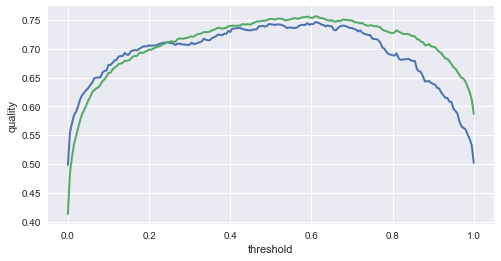

In [86]:
lr_p, lr_pr = combine_results(lr_res, cv, df_p.shape[0])
review(df_p, lr_p, lr_pr, "ibs")

In [115]:
lr_p3 = np.zeros(len(lr_p))
lr_p3[lr_pr > 0.61] = 1
print accuracy_score(df_p["ibs"], lr_p3)

0.756395995551


In [107]:
xgb_f = [u'S_FirstRPeaks', u'S_LastRPeaks',
             u'S_MedianRPeaks', u'S_Activity', u'S_Mobility', u'S_Complexity',
             u'FS_mean', u'FS_std', u'FS_min', u'FS_max',
       u'FS_5', u'FS_5sg', u'FS_5sl', u'FS_5sg2', u'FS_5sl2', u'FS_10',
       u'FS_10sg', u'FS_10sl', u'FS_10sg2', u'FS_10sl2', u'FS_25', u'FS_25sg',
       u'FS_25sl', u'FS_25sg2', u'FS_25sl2', u'FS_50', u'FS_50sg', u'FS_50sl',
       u'FS_50sg2', u'FS_50sl2', u'FS_75', u'FS_75sg', u'FS_75sl', u'FS_75sg2',
       u'FS_75sl2', u'FS_90', u'FS_90sg', u'FS_90sl', u'FS_90sg2', u'FS_90sl2',
       u'FS_95', u'FS_95sg', u'FS_95sl', u'FS_95sg2', u'FS_95sl2', u'FS_5-10',
       u'FS_5-25', u'FS_5-50', u'FS_5-75', u'FS_5-90', u'FS_5-95', u'FS_10-25',
       u'FS_10-50', u'FS_10-75', u'FS_10-90', u'FS_10-95', u'FS_25-50',
       u'FS_25-75', u'FS_25-90', u'FS_25-95', u'FS_50-75', u'FS_50-90',
       u'FS_50-95', u'FS_75-90', u'FS_75-95', u'FS_90-95', u'S_Skew',
       u'S_Kurt'] 
xgb_f += vu_columns
xgbclf_params = {"objective":"binary:logistic", "max_depth":7, "learning_rate":0.05,
                 "n_estimators": 300, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"auc", "early_stopping_rounds":900, "verbose": False}

In [112]:

xgb_res = cv_fit_predict(xgb.XGBClassifier, cv_train_test, xgb_f, xgbclf_params, xgbfit_params, do_scaling = True, xgbfit = True)


100%|██████████| 12/12 [00:50<00:00,  4.28s/it]


roc-auc = 0.803514635811
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.728031145717
Качество по людям = 0.727836950151
Наилучшее разбиение происходит при границе 0.445
Качество по сигналам = 0.734149054505
Качество по людям = 0.734462880895


0.73446288089478518

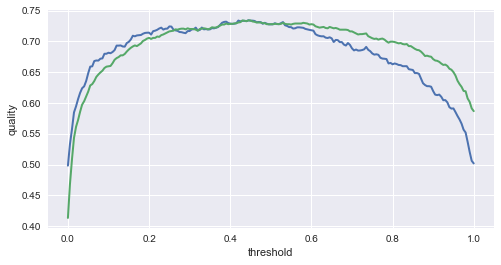

In [113]:
xgb_a, xgb_pr = combine_results(xgb_res, cv, df_p.shape[0])
review(df_p, xgb_a, xgb_pr, "ibs")

In [116]:
xgb_p3 = np.zeros(len(xgb_a))
xgb_p3[xgb_pr > 0.445] = 1
print accuracy_score(df_p["ibs"], xgb_p3)

0.734149054505


In [117]:
new_df = pd.DataFrame(data={"ibs":df_p["ibs"], "ECG_ID":df_p["ECG_ID"], 
                            "STAT_PR_LR":lr_pr,
                            "STAT_P_LR":lr_p,
                            "STAT_P_NEW_LR":lr_p3,
                            "STAT_PR_XGB":xgb_pr,
                            "STAT_P_XGB":xgb_a,
                            "STAT_P_NEW_XGB":xgb_p3})

In [121]:
new_df.to_csv("stat_results.csv")